# CQF | Exam 3 (Machine Learning Assigment)

## Vladimir Malygin

The Hague, April 2020

-----

### A. Predicting Price Direction
### Preprocessing


In the preprocessing section, we proceed as follows <br>
* download the data;
* construct features;
* investigate relationships visually and using correlation matrix;

#### Download the data

We download OCHL prices and Volume data for two companies that operate in Oil & Gas industry. We use Yahoo! Finance as data provider. To download the data, we import yfinance package.

In [2]:
import yfinance as yf

Let us download the data for two companies that operate in Oil & Gas industry:
* Cabot Oil & Gas Corp (COG);
* Exxon Mobil Corp: XOM (XOM).

In [3]:
COG_data = yf.download("COG", start="2000-01-01", end="2020-01-31", period = '1d')
XOM_data = yf.download("XOM", start="2000-01-01", end="2020-01-31", period = '1d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Let us take a look at the dataframe for COG.

In [4]:
COG_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,1.348958,1.348958,1.317708,1.338542,0.747890,252800
2000-01-03,1.338542,1.338542,1.218750,1.234375,0.689689,1306400
2000-01-04,1.223958,1.223958,1.192708,1.197917,0.669318,334400
2000-01-05,1.187500,1.223958,1.187500,1.218750,0.680959,363200
2000-01-06,1.213542,1.270833,1.208333,1.244792,0.695509,538400


Let us download several addition libraries for further analysis.

In [5]:
import pandas as pd
import numpy as np
from pylab import plt
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

In [6]:
COG_adj_close = COG_data['Adj Close']

We plot the adjusted close price for Cabot Oil & Gas Corp by using pylab package.

Text(0, 0.5, 'Adjusted Close Price, USD')

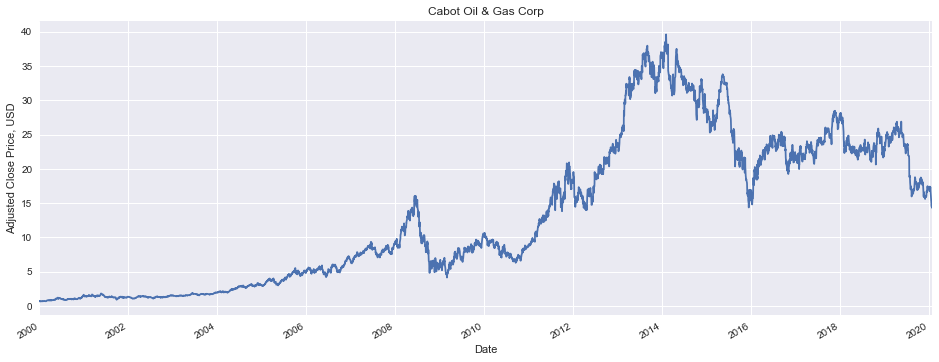

In [7]:
COG_adj_close.plot(figsize=(16, 6))
plt.title('Cabot Oil & Gas Corp')
plt.ylabel('Adjusted Close Price, USD')

#### Construct features

Now, let us construct features. As the assignment prescribes, we use *Open, Close, High Low, Adjusted Close prices, Volume* (added for a personal interest), *lagged returns (up to 8 lags), the lagged returns over 5 and 21 day, 1 and 5-day difference between lagged adjusted close prices, 5-day moving average, 7-day exponential moving average and 21-day rolling volatility*. <br> It seems logical to assume that some of these features will be highly correlated.

In [8]:
df = pd.DataFrame() # create empty pandas dataframe
df['return'] = np.log(COG_adj_close / COG_adj_close.shift(1)) # create logarithmic returns
df['return_sign'] = np.sign(df['return']) # create a categorical variable with two classes: 1 for a positive return and -1 for a negative return

In [9]:
##### function below allows us to compute exponential moving average in a way consistent with the assignment

def EMAcreate(price, period):
    modifiedPrice = price.copy()
    sma_period = price.rolling(period).mean()
    modifiedPrice.iloc[0:period] = sma_period[0:period]
    ema_period = modifiedPrice.ewm(span=period, adjust=False).mean()
    return ema_period

df['Adj Close'] = COG_data['Adj Close'].shift(1) # lagged adjusted close price
df['Open'] = COG_data.Open.shift(1) # lagged open price
df['Close'] = COG_data.Close.shift(1) # lagged close price
df['High'] = COG_data.High.shift(1) # lagged high price
df['Low'] = COG_data.Low.shift(1) # lagged low price
df['Volume'] = COG_data.Volume.shift(1) # lagged Volume

# Below, we create lagged returns

lags = 8
cols = []
for lag in range(1, lags+1):
    col_ret = 'ret_%d' % lag
    df[col_ret] = df['return'].shift(lag)
    cols.append(col_ret)

In [10]:
df['ret_over_5d'] = np.log(df['Adj Close'] / df['Adj Close'].shift(5)) # lagged 5-day return
df['ret_over_21d'] = np.log(df['Adj Close'] / df['Adj Close'].shift(21)) # lagged 21-day return
df['MOM_1d'] = df['Adj Close'].diff(1) # lagged 1-day adjusted close price difference
df['MOM_5d'] = df['Adj Close'].diff(5) # lagged 5-day adjusted close price difference
df['MA_5d'] = df['Adj Close'].rolling(5).mean() # lagged 5-day adjusted close price moving average 
df['EMA_7d'] = EMAcreate(df['Adj Close'], 7) # lagged 7-day adjusted close price exponential moving average 
df['std_21d'] = df['ret_1'].rolling(21).std() # based on 1-day log return, 21-day return standart deviation
df.dropna(inplace = True)

Let us take a look at the final dataframe, which contains both our features and categorical variable we would like to predict (returns).

In [11]:
df.head(5)

,return,return_sign,Adj Close,Open,Close,High,Low,Volume,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_over_5d,ret_over_21d,MOM_1d,MOM_5d,MA_5d,EMA_7d,std_21d
Date,,,,,,,,,,,,,,,,,,,,,,,
2000-02-02,0.000000,0.0,0.71297,1.239583,1.276042,1.281250,1.239583,682400.0,0.037427,-0.016807,-0.004158,-0.044632,0.065597,0.000000,-0.037427,0.004090,0.037427,-0.047818,0.026191,0.026191,0.706567,0.701976,0.035504
2000-02-03,0.028171,1.0,0.71297,1.281250,1.276042,1.286458,1.255208,357600.0,0.000000,0.037427,-0.016807,-0.004158,-0.044632,0.065597,0.000000,-0.037427,-0.028171,0.033198,0.000000,-0.020370,0.702493,0.704724,0.030581
2000-02-04,-0.003977,-1.0,0.73334,1.286458,1.312500,1.328125,1.286458,869600.0,0.028171,0.000000,0.037427,-0.016807,-0.004158,-0.044632,0.065597,0.000000,0.044632,0.091350,0.020370,0.032011,0.708896,0.711878,0.030211
2000-02-07,0.000000,0.0,0.73043,1.307292,1.307292,1.322917,1.307292,1332800.0,-0.003977,0.028171,0.000000,0.037427,-0.016807,-0.004158,-0.044632,0.065597,0.044814,0.070131,-0.002910,0.032011,0.715298,0.716516,0.030113
2000-02-08,-0.020121,-1.0,0.73043,1.307292,1.307292,1.317708,1.291667,320000.0,0.000000,-0.003977,0.028171,0.000000,0.037427,-0.016807,-0.004158,-0.044632,0.061621,0.048989,0.000000,0.043651,0.724028,0.719995,0.029840


Let us take a look at the categorical returns. The method np.sign() indeed returns the sign, but if the return is equal to zero, it will return 0. Of course, it will create the third class for us, which we do not need. There are a couple of options here. We either specify zero return as a positive return or exlude zero returns from our sample. We stick to the latter option.

In [12]:
np.unique(np.array(df['return_sign']))

array([-1.,  0.,  1.])

We see that there are values, which are zeros. Let us drop these values.

In [13]:
df = df.loc[~(df==0.0).all(axis=1)]
df = df[df!=0].dropna()
np.unique(np.array(df['return_sign']))

array([-1.,  1.])

####  Visual inspection and correlation analysis

Now, it looks fine. Let visually investigate some relationships in our data. For example, we can simply look at the relationship return with all other predictors.

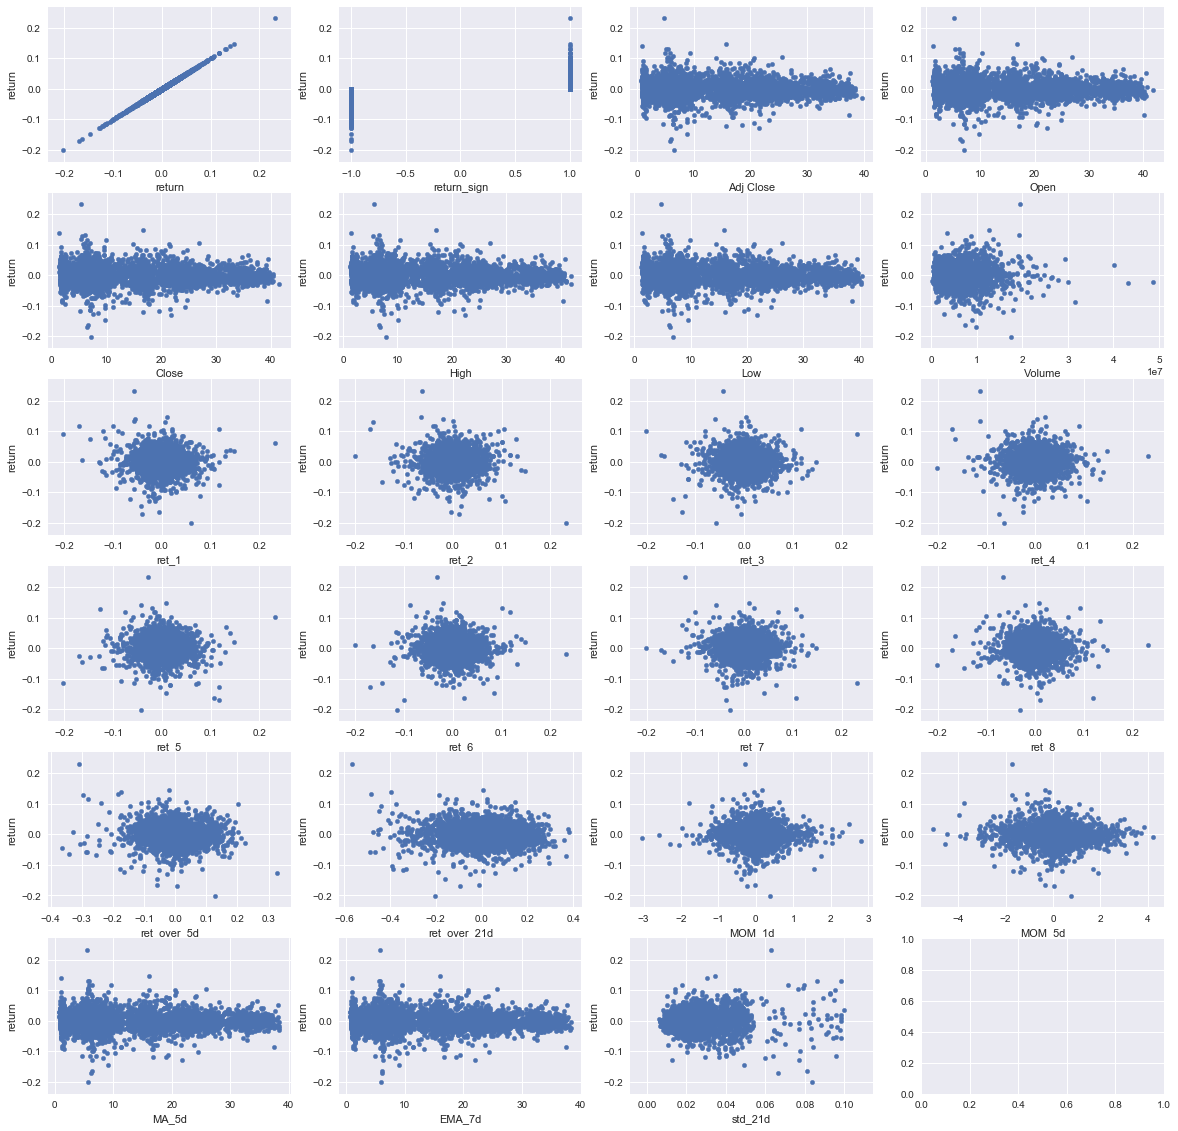

In [14]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(df.columns):
    df.plot(feature, "return", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

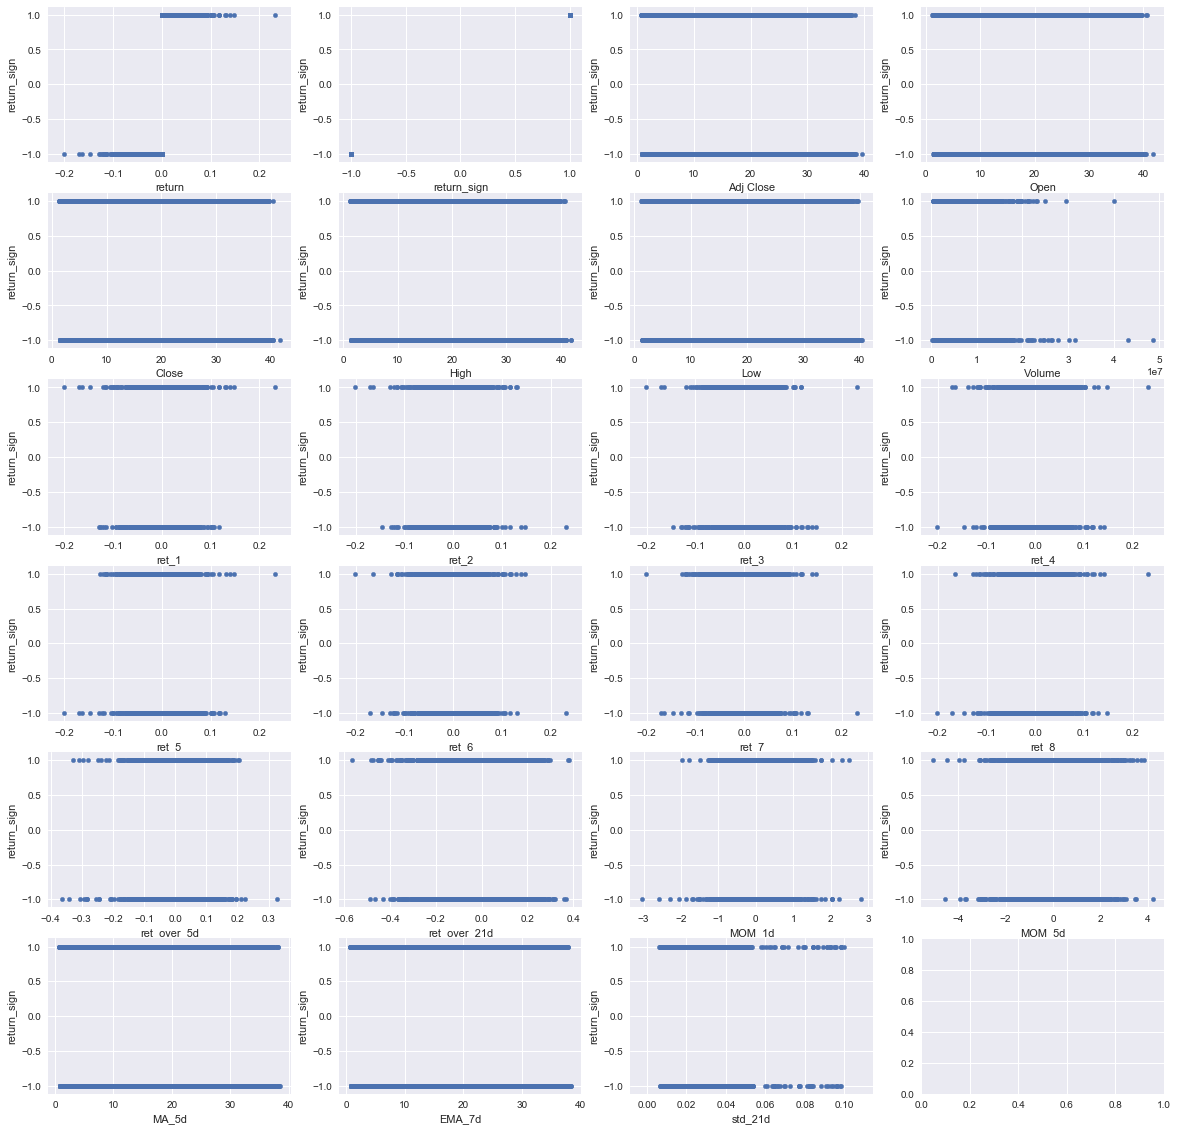

In [15]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(df.columns):
    df.plot(feature, "return_sign", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

In [16]:
df.iloc[:,2:].corr()

,Adj Close,Open,Close,High,Low,Volume,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_over_5d,ret_over_21d,MOM_1d,MOM_5d,MA_5d,EMA_7d,std_21d
Adj Close,1.000000,0.999177,0.999700,0.999480,0.999470,0.257402,-0.006802,-0.008477,-0.007365,-0.009042,-0.009424,-0.012991,-0.012394,-0.015442,-0.019049,-0.040314,0.013369,0.028196,0.999298,0.999280,-0.221700
Open,0.999177,1.000000,0.999471,0.999748,0.999739,0.253855,-0.028780,-0.007034,-0.005895,-0.007864,-0.007960,-0.010916,-0.011774,-0.014468,-0.026619,-0.040633,-0.014343,0.017974,0.999195,0.999080,-0.221225
Close,0.999700,0.999471,1.000000,0.999776,0.999758,0.253252,-0.005992,-0.007653,-0.006419,-0.008103,-0.008537,-0.012094,-0.011409,-0.014453,-0.017008,-0.035996,0.014083,0.030047,0.998944,0.998895,-0.220547
High,0.999480,0.999748,0.999776,1.000000,0.999683,0.260157,-0.017416,-0.007320,-0.006762,-0.008276,-0.009068,-0.011927,-0.011945,-0.014796,-0.022613,-0.039890,0.000091,0.023397,0.999111,0.999047,-0.215740
Low,0.999470,0.999739,0.999758,0.999683,1.000000,0.246205,-0.016826,-0.006298,-0.005533,-0.007588,-0.007447,-0.010965,-0.011492,-0.014404,-0.020227,-0.036765,0.000151,0.025315,0.999068,0.998974,-0.226629
Volume,0.257402,0.253855,0.253252,0.260157,0.246205,1.000000,-0.022497,-0.069078,-0.063668,-0.059111,-0.069890,-0.037564,-0.059267,-0.044778,-0.131742,-0.205005,-0.006793,-0.102734,0.259731,0.261346,0.384491
ret_1,-0.006802,-0.028780,-0.005992,-0.017416,-0.016826,-0.022497,1.000000,-0.026368,-0.006506,-0.009309,-0.028035,-0.028944,0.005229,-0.010180,0.429071,0.206425,0.789270,0.342840,-0.028336,-0.026679,0.014159
ret_2,-0.008477,-0.007034,-0.007653,-0.007320,-0.006298,-0.069078,-0.026368,1.000000,-0.024924,-0.009419,-0.009988,-0.029762,-0.026084,0.005552,0.429225,0.198430,-0.026850,0.333767,-0.023992,-0.022664,0.002450
ret_3,-0.007365,-0.005895,-0.006419,-0.006762,-0.005533,-0.063668,-0.006506,-0.024924,1.000000,-0.027075,-0.006414,-0.009273,-0.028983,-0.028101,0.433733,0.197096,-0.005700,0.339989,-0.017607,-0.017906,0.003386
ret_4,-0.009042,-0.007864,-0.008103,-0.008276,-0.007588,-0.059111,-0.009309,-0.009419,-0.027075,1.000000,-0.022447,-0.007573,-0.012983,-0.030660,0.433665,0.201944,-0.015225,0.334534,-0.013668,-0.016536,-0.005512


We can conclude see from the plots above and the correlation matrix? Actually, it is hard to see any strong linear relationships between the feautres and our target variable (return_sign) by looking at the plots. One of my hypothesis is that a logistic regression is not a very good estimator for forecasting 1-day returns.<br>
We also see that prices are considerably correlated, so I would expect a multicollinearity problem here. I would not added highly correlated featurs. However, let us use all features for some time until we decide to improve our performance or face with some serious issues.

Let us define the matrix with features X and vector with labels (return sign) using iloc method.

In [17]:
features_names = ['Adj Close', 'Open', 'Close', 'High', 'Low',
                  'Volume', 'ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5', 'ret_over_5d',
                  'ret_over_21d', 'MOM_1d', 'MOM_5d', 'MA_5d', 'EMA_7d', 'std_21d',
                  'ret_6', 'ret_7', 'ret_8']

In [18]:
X = df[features_names] # features data set
y = df['return_sign'] # object to predict

### Classifier A.1 Logistic Classifier and Bayesian Classifier

**a)** Make sure to implement penalised versions of logistic regression and discuss impact on coefficients. Apply and discuss the difference between L1 and L2 cost functions, the impact made on regression coeffi- cients (comparison table recommended). **b)** Demonstrate the use of sklearn.model selection for reshuffled samples and k-fold crossvalidation.

The outline of this part of the assignment is the following:
* Recite necessary math for Logistic Classifier.
* Separately consider L1 and L2 version of legularization, find optimal inverse of regularization strength (using GridSearchCV just here and for feature selection AND hyperparameter selection later in the assignment) parameter and discuss impact on coefficients.
* Split the data set on training and test subsamples and evaluate alogorithms.
* Demonstrate the use of sklearn.model selection for reshuffled samples and k-fold crossvalidation in part b).

<br><br>

**Theoretical background for Logistic Classifier**
<br>

Logistic regression predicts the probability of which class the object belongs to. The sum of answers of the logistic regression on one object for all classes is equal to one. In our case, we have two classes.


$$ \sum_{k=1}^K \pi_{ik} = 1, \quad \pi_k \equiv P\,(y_i = k \mid x_i, \theta), $$

where:
- $\pi_{ik}$ - the probability of belonging object $x_i$ from sample $X$ to class $k$
- $\theta$ - internal parameters of the algorithm, which are set up during learning pricess. In case of longistic regression - $w, b$

From this propery of the model, in case of binary classification, it is required only to compute the probability of belonging an object to one of the classes. This probability is computed, using logistic function:


$$ P\,(y_i = 1 \mid x_i, \theta) = \frac{1}{1 + \exp(-w^T x_i-b)} $$

Paremeters $w$ и $b$ are found by solving the following optimization problem (functionals with L1 и L2 regularization).

L2-regularization:

$$ Q(X, y, \theta) = \frac{1}{2} w^T w + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

L1-regularization:

$$ Q(X, y, \theta) = \sum_{d=1}^D |w_d| + C \sum_{i=1}^l \log ( 1 + \exp(-y_i (w^T x_i + b ) ) ) \longrightarrow \min\limits_{w,b} $$

$C$ - standart hyperparameter of the model (**inverse of regularization strength**), which regulates how much we help our model to fits the data.

#### Features scaling (relevant to A.3)

**Train and test split**

We have 4505 observations. Let us take approximately 75% for traning. It is about 1100 observations.<br>
Also, it is known that logistic regression is quite sensitive to the amplitude of features. Because of this, I scale the features usings StandardScaler from sklearn.preprocessing. I am aware that we need scale the featurs later in the assignment, but it should be fine if we also do this here.

In [180]:
size = 1100

train_y = y[:-size]
test_y = y[-size:]

train_X = X.iloc[:-size,:]
test_X = X.iloc[-size:,:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

X_scaled = np.concatenate((train_X_scaled, test_X_scaled), axis=0)

In [179]:
test_X_scaled

array([[ 1.53175787e+00,  1.50159236e+00,  1.51783094e+00, ...,
         4.81395491e-01,  1.89104432e-01, -8.83766694e-05],
       [ 1.48063769e+00,  1.48864682e+00,  1.46601104e+00, ...,
         1.18525667e+00,  4.79743075e-01,  1.88767977e-01],
       [ 1.49798175e+00,  1.39987698e+00,  1.48359269e+00, ...,
        -1.28737406e-01,  1.18231356e+00,  4.80310509e-01],
       ...,
       [ 3.47990297e-01,  2.61589895e-01,  2.53794345e-01, ...,
        -1.22069392e+00,  2.25309097e-02, -3.92992066e-01],
       [ 3.75734132e-01,  2.61589895e-01,  2.80629672e-01, ...,
        -2.91815782e+00, -1.21922515e+00,  2.16764097e-02],
       [ 3.38423419e-01,  2.83782311e-01,  2.44540747e-01, ...,
        -2.48708518e-01, -2.91357636e+00, -1.22394152e+00]])

**L1-regularization:**

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]} # regularization parameters
cv = 3 # number of folds for k-fold in grid search
penalty = 'l1' # regularization type

In [21]:
estimator_logistic_l1 = LogisticRegression(penalty, solver='liblinear', max_iter = 1000) # create esimator
optimizer_logistic_l1 = GridSearchCV(estimator_logistic_l1, param_grid, scoring = 'accuracy', cv = cv) # perform grid search

In [22]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.title('Grid search to find the optimal parameter C (inverse of regularization strength)')
    plt.xlabel('Hyperparameter C')
    plt.ylabel('Score')
    plt.show()

An interesting thing we do below is the hyperparameter selection using GridSearchCV (more about it below).

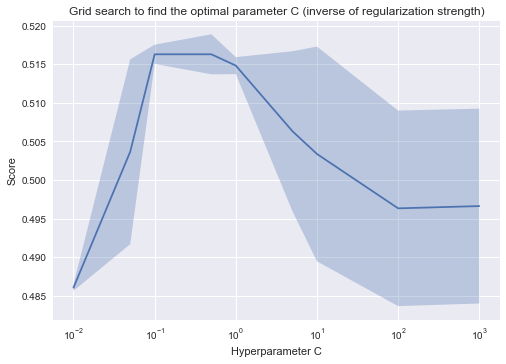

In [23]:
optimizer_logistic_l1.fit(train_X_scaled,  train_y)
plot_scores(optimizer_logistic_l1)

In [24]:
logistic_l1_coef = optimizer_logistic_l1.best_estimator_.coef_.ravel()
print('Training set coefficients: ')
print(logistic_l1_coef)
print()
print('The best parameter:')
print(optimizer_logistic_l1.best_params_)


Training set coefficients: 
[ 0.          0.         -0.0991541   0.          0.         -0.0225411
  0.          0.04852767  0.         -0.03839275  0.          0.
 -0.05162265  0.         -0.02210439  0.          0.          0.
 -0.01046163  0.0043314   0.00124791]

The best parameter:
{'C': 0.1}


Now, let us check the outcome on the test sample.

In [25]:
logistic_l1_prediction = optimizer_logistic_l1.predict(test_X_scaled)
logistic_l1_auc = roc_auc_score(test_y, logistic_l1_prediction)
print('L1-model auc:')
print(logistic_l1_auc)

L1-model auc:
0.5050347273875286


**L2-regularization:**

In [26]:
penalty = 'l2'
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 
                    0.5, 1, 5, 10, 100, 1000]} # regularization parameters

In [27]:
estimator_logistic_l2 = LogisticRegression(penalty, solver='liblinear', max_iter = 1000)
optimizer_logistic_l2 = GridSearchCV(estimator_logistic_l2, param_grid, scoring = 'accuracy', cv = cv)

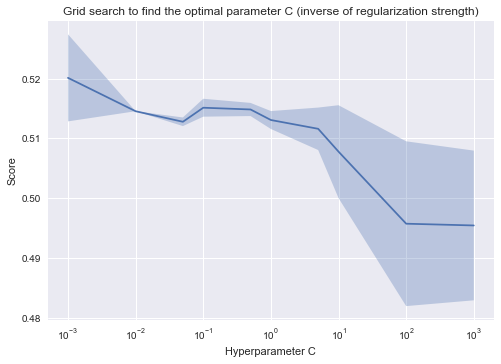

In [28]:
optimizer_logistic_l2.fit(train_X_scaled,  train_y)
plot_scores(optimizer_logistic_l2)

In [29]:
logistic_l2_prediction = optimizer_logistic_l2.predict(test_X_scaled)
logistic_l2_auc = roc_auc_score(test_y, logistic_l2_prediction)
print('L2-model auc:')
print(logistic_l2_auc)

L2-model auc:
0.5043256341343277


In [30]:
logistic_l2_coef = optimizer_logistic_l2.best_estimator_.coef_.ravel()
print('Training set coefficients: ')
print(logistic_l2_coef)
print()
print('The best parameter:')
print(optimizer_logistic_l2.best_params_)
print()
print('The best achieved score:')
print(optimizer_logistic_l2.best_score_)

Training set coefficients: 
[-0.0135589  -0.01384109 -0.01438896 -0.01391013 -0.01407397 -0.01479158
  0.00110715  0.02492349 -0.00669275 -0.02581647  0.00155482 -0.00238101
 -0.02727596 -0.00781367 -0.01509663 -0.01304668 -0.0127244   0.00254684
 -0.01240848  0.00543589  0.00428344]

The best parameter:
{'C': 0.001}

The best achieved score:
0.5201174743024963


Let us show the coefficients we obtained from **l1** and **l2** regularization:

In [31]:
estimator_logistic_plain = LogisticRegression(solver='liblinear', max_iter = 1000)
estimator_logistic_plain.fit(train_X_scaled,  train_y)
estimator_logistic_plain_coefficeints = estimator_logistic_plain.coef_
estimator_logistic_plain_coefficeints = estimator_logistic_plain_coefficeints.reshape(21,1)

In [32]:
coefficientsMatrix = pd.concat([round(pd.DataFrame(logistic_l1_coef), 3), 
                                round(pd.DataFrame(logistic_l2_coef),3),
                                round(pd.DataFrame(estimator_logistic_plain_coefficeints),3)], axis = 1)
coefficientsMatrix.columns = ['L1 Coefficients', 'L2 Coefficeints', 'No regularization']
coefficientsMatrix.set_index(X.columns)

,L1 Coefficients,L2 Coefficeints,No regularization
Adj Close,0.000,-0.014,0.112
Open,0.000,-0.014,-0.123
Close,-0.099,-0.014,-0.558
High,0.000,-0.014,-0.064
Low,0.000,-0.014,-0.346
Volume,-0.023,-0.015,-0.043
ret_1,0.000,0.001,0.020
ret_2,0.049,0.025,0.068
ret_3,0.000,-0.007,-0.004
ret_4,-0.038,-0.026,-0.049


**Conclusion to a):** <br>
Quite interesting results. Indeed, we see that regularization works. L1 regularization sets some of the coefficients to zero and l2 regularization reduces the coefficients' amplitude. As I hypothesized above, all prices beside one were set to zero in l1 regularization and it is clear why (see correlation matrix). Also, the features based on moving average seems to be wiped out by l1 regularization. It is likely due to the same reason.

**b) Demonstrate the use of sklearn.model selection for reshuffled samples and k-fold crossvalidation.** <br><br>
Below, I make a split of the sample by using *model_selection.train_test_split*. Then, I scale the features to avoid problems with the convergence. Then, I find the optimal model using GridSearchCV. I fit the model using the created train sample and perform cross validation by using *cross_validate* class.

In [33]:
from sklearn import model_selection
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import train_test_split

In [34]:
train_X_shuffle, test_X_shuffle, \
train_y_shuffle, test_y_shuffle = model_selection.train_test_split(X, y, test_size = 0.25, shuffle = True)

In [35]:
scaler = StandardScaler()
train_X_scaled_shuffle = scaler.fit_transform(train_X_shuffle)
test_X_scaled_shuffle = scaler.transform(test_X_shuffle)

In [36]:
cv = 3
penalty = 'l2'
param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                    0.5, 1, 5, 10, 100, 1000]} # regularization parameters

estimator = LogisticRegression(penalty, solver='liblinear', max_iter = 3000) # create esimator
optimizer = GridSearchCV(estimator, param_grid, cv = cv) # perform grid search

In [37]:
optimizer.fit(train_X_scaled_shuffle,  train_y_shuffle)
logistic_l2_prediction_shuflled = optimizer.predict(test_X_scaled_shuffle)
logistic_l2_auc = roc_auc_score(test_y, logistic_l2_prediction)
print('L2-model auc:')
print(logistic_l2_auc)

L2-model auc:
0.5043256341343277


In [38]:
scores = cross_validate(optimizer, train_X_scaled_shuffle, train_y_shuffle, cv=3, 
                        scoring=('roc_auc'), return_train_score=True)

In [39]:
scores

{'fit_time': array([0.23186898, 0.25183415, 0.25037098]),
 'score_time': array([0.00145292, 0.00143886, 0.00139999]),
 'test_score': array([0.50841139, 0.54076073, 0.50666035]),
 'train_score': array([0.55702809, 0.53411167, 0.54696653])}

___

<br>



### Classifier A.2 Support Vector Machines

**Theoretical background for Support Vector Machines**
<br>



##### Hard Margin <br>
If the training data is linearly separable, we can select two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible. <br>

$$ \frac{1}{2}||w||^{2}  \longrightarrow \min\limits_{w, b} $$ <br>
subject to:
$$ y_i (w^T x_i + b ) \geq 1 $$

##### Soft Margin <br>
When the data is not linearly separable, we need somehow allow the algorithm to cope with this problem. Therefore, we introduce $\xi_i$ term and put it both in the optimization funtion and constraint. In our optimization function, we also see hyperparameter $C$ to account for $\xi_i$ term. After substituting $\xi_i$ in our optimiation problem, we obtain unconditional optimization. Thus, we obtain hidge loss function and l2 regularization.

$$ \frac{1}{2}||w||^{2} + C \sum_{i=1}^l \xi_i   \longrightarrow \min\limits_{w,b, \xi} $$ <br>
subject to:
$$ y_i (w^T x_i + b ) \geq 1 - \xi_i $$
$$ \xi_i \geq 0$$

The impact on the 2D relationship should be material. I believe it will be nearly impossible to distinct two classes. That is why we need to soften margins at some extent.<br>
Below, we consider two cases: *hard margins* and *soft margins* based on two dimensional space (Momentum Feature 5-day vs 1-day lagged return) and provide visualisation.

In [40]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

First of all, we consider the case with **hard margin** by setting parameter $C = 1000$.

In [41]:
feature_space_2D = train_X_scaled[:,[12,14]] # column indeces of 5-day momentum and 1-day lagged return are 12 and 14
hard_margin = 1000

In [42]:
SVM_2D_hard = SVC(C=hard_margin, probability=True)
SVM_2D_hard = SVM_2D_hard.fit(feature_space_2D, train_y)

In [43]:
# Plot the decision function for a 2D SVC (from notes)
def plot_svc_decision_function(model, ax=None, plot_support=True): 
    if ax is None:
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xlim = (-3, 3)
        x = np.linspace(xlim[0], xlim[1], 30)
        y = np.linspace(ylim[0], ylim[1], 30)
        Y, X = np.meshgrid(y, x)
        xy = np.vstack([X.ravel(), Y.ravel()]).T
        P = model.decision_function(xy).reshape(X.shape)
        ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
        linestyles=['--', '-', '--'])
    if plot_support: 
        ax.scatter(model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=300, linewidth=1, facecolors='none') 
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

Text(0, 0.5, 'MOM_5d')

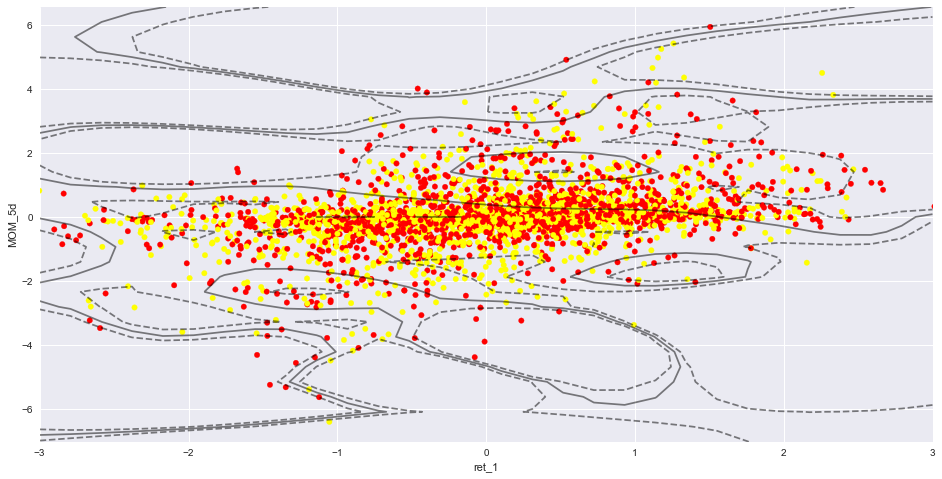

In [44]:
plt.clf
plt.figure(figsize=(16, 8)) #facecolor='w'
plt.scatter(feature_space_2D[:,0], feature_space_2D[:,1], 
            c=train_y, s=30, cmap='autumn') 
plot_svc_decision_function(SVM_2D_hard)
plt.xlabel('ret_1')
plt.ylabel('MOM_5d')

Let us try a **soft margin**. We look what is happening if we set $C = 10$

In [497]:
soft_margin = 10
SVM_2D_soft = SVC(C=soft_margin, probability=True)
SVM_2D_soft.fit(feature_space_2D, train_y)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Text(0, 0.5, 'MOM_5d')

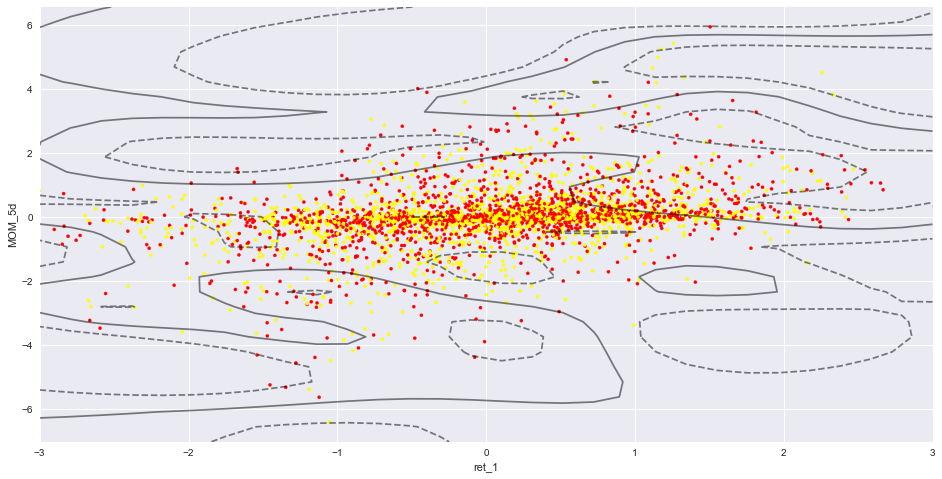

In [498]:
plt.clf
plt.figure(figsize=(16, 8)) #facecolor='w'
plt.scatter(feature_space_2D[:,0], feature_space_2D[:,1], 
            c=train_y, s=10, cmap='autumn') 
plot_svc_decision_function(SVM_2D_soft)
plt.xlabel('ret_1')
plt.ylabel('MOM_5d')

There is a quite some difference. Boundaries changed considerable. It seems that the separation goes a little bit better. However, it looks that we do not need to soften a lot because if our training sample differs from a population, the algorithm will not perform well. However, we cannot say much about it without further testing.

**Conclusion to A.2:** it seems that SVM is a powerful algorithm. In two dimensions that we used, it does not look that it is well separable, however, perhaps the change of a kernel could help us. In the situation when we know that the observations are not easy to separate, we need to soften our margins in order to optimize our loss function.<br>
___

<br>

### Classifier A.3 K-Nearest Neighbours

**KNN** is a relatively simple algorithm, but it has a variety of modifications. Today, we consider its modifications in terms of a metric **(Manhattan, Euclidean, Mahalanobis)** and consider various values of hyperparameter **number of neighbours**.

**Theoretical background for Metrics (KNN)**
<br>




Since it is quite important to measure a distance in this algoirthm, I decided to focus my attention on metrics' math.

##### Manhattan distance

The distance between a point $P$ and a line $L$ is defined as the
smallest distance between any point $M\in L$ on the line and $P$:



\begin{equation*}
  d(P,L) \equiv \min_{M\in L} d(M,P)
\end{equation*}

Thus, we can write down Manhattan distance as follows

\begin{equation*}
  d(M,P) \equiv |M_x-P_x|+|M_y-P_y|
\end{equation*}

##### Minkovskiy distance (Euclidean when p=2)

Let us write Minkovskiy distance instead of writing only Euclidean distance. We can do this because if p=2, Minkovskiy distance is nothing but Euclidean distance.

The Minkowski distance of order $p$ between two points $X$ and $Y$:




$${\displaystyle X=(x_{1},x_{2},\ldots ,x_{n}),Y=(y_{1},y_{2},\ldots ,y_{n})\in \mathbb {R} ^{n}}$$



can be written as follows
$${\displaystyle D_p\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$

The p-norm of a vector ${\displaystyle \mathbf {x} =(x_{1},\ldots ,x_{n})}$ is

$$\left\|\mathbf {x} \right\|_{p}:={\bigg (}\sum _{i=1}^{n}\left|x_{i}\right|^{p}{\bigg )}^{1/p}$$

By default, Eucledian is **not** a scale in-variant metric. Therefore, the computed distances might be skewed depending on the units of the features. One needs to normalize the data points before using Eucledian distance. That is why we will scale our features below (as we did in case of logistic classifier).

##### Mahalanobis distance

It’s also known as squared interpoint distance. Mahalanobis distance is **scale-invariant**, unitless and considers the correlation between variables. Unlike Eucledian distance, Mahalobis distance accounts for the correlation between variables

The Mahalanobis distance of an observation ${\displaystyle {\vec {x}}=(x_{1},x_{2},x_{3},\dots ,x_{N})^{T}}$  from  from a set of observations with mean $\mu$ and covariance matrix $S$ is defined as

##### $${\displaystyle D_{M}({\vec {x}})={\sqrt {({\vec {x}}-{\vec {\mu }})^{T}S^{-1}({\vec {x}}-{\vec {\mu }})}}.\,}$$

Since necessary elements are defined above, let us shortly summarize what the algorithm is about and why we need the aforementioned metrics. The algorithm is relatively simple because actually it assigns an element to a class by looking at its neighbours by measuring the distance. That is why metrics are so important here.<br>
Below, we are going to do the following.

___

<br>

**a) Given KNN’s dependence on distance computation scale the features, eg, StandardScaler from sklearn.preprocessing.**

We have already done this step in **A1**. I will restate it again below for convinience.

In [47]:
size = 1100

train_y = y[:-size]
test_y = y[-size:]

train_X = X.iloc[:-size,:]
test_X = X.iloc[-size:,:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

**b) Report on sensible values for n neighbors hyperparameter and provide compar- ison of metric, particularly Manhattan vs Euclidean vs Mahalanobis – see DistanceMetric class.**

**Experiment with Euclidean metric**

First of all, let us start with KNN algorithm based on euclidean metric.<br>

In [48]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric

In [49]:
estimator_euclidean = KNeighborsClassifier(metric = 'euclidean') # set up KNN estimator
param_grid = {'n_neighbors': np.arange(1,100, 1).tolist()} # set up the number of neighbours

Let us perform GridSearch to figure out the optimal number of neighbours, we do this analysis using cross validation technique.

In [50]:
cv = 3
optimizer = GridSearchCV(estimator_euclidean, param_grid, scoring = 'accuracy', cv = cv) 

In [51]:
optimizer.fit(train_X_scaled, train_y)
estimator_euclidean.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')>

From the output above, we document that the optimal value of the hyperparameter in case of **Euclidean metric is k=5**.

In [52]:
print('The accuracy of the optimized KNN algorithm based on Euclidean metric:')
KNeighborsClassifier.score(optimizer, test_X_scaled, test_y)

The accuracy of the optimized KNN algorithm based on Euclidean metric:


0.5045454545454545

The result is not promising though.

**Experiment with Manhattan metric**

In [53]:
estimator_manhattan = KNeighborsClassifier(metric = 'manhattan')
optimizer_manhattan = GridSearchCV(estimator_manhattan, param_grid, 
                                   scoring = 'accuracy', cv = cv) # perform grid search

In [54]:
optimizer_manhattan.fit(train_X_scaled, train_y)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='manhattan',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

From the output above, we document that the optimal value of the hyperparameter in case of **Manhattan metric is k=5**.

In [55]:
print('The accuracy of the optimized KNN algorithm based on Manhattan metric:')
KNeighborsClassifier.score(optimizer_manhattan, test_X_scaled, test_y)

The accuracy of the optimized KNN algorithm based on Manhattan metric:


0.509090909090909

**Experiment with Mahalanobis metric**

In [56]:
k = 11
estimator_mahalanobis = KNeighborsClassifier(n_neighbors=k, metric = 'mahalanobis', algorithm='brute', metric_params={'V': np.cov(train_X_scaled)})
optimizer_mahalanobis = GridSearchCV(estimator_manhattan,  param_grid, scoring = 'accuracy', cv = cv) # perform grid search

In [57]:
estimator_mahalanobis.fit(train_X_scaled, train_y)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='mahalanobis',
                     metric_params={'V': array([[ 0.80638786,  0.78974302,  0.82396295, ..., -0.28824389,
        -0.26222688, -0.22677297],
       [ 0.78974302,  0.95529275,  0.91650327, ..., -0.31294046,
        -0.36329297, -0.29216418],
       [ 0.82396295,  0.91650327,  1.04296579, ..., -0.42355279,
        -0.3473215 , -0.35267463],
       ...,
       [-0.28824389, -0.31294046, -0.42355279, ...,  0.78605675,
         0.64802756,  0.4858406 ],
       [-0.26222688, -0.36329297, -0.3473215 , ...,  0.64802756,
         0.84001853,  0.63847887],
       [-0.22677297, -0.29216418, -0.35267463, ...,  0.4858406 ,
         0.63847887,  0.80249595]])},
                     n_jobs=None, n_neighbors=11, p=2, weights='uniform')

In [58]:
print('The accuracy of the optimized KNN algorithm based on Manhattan metric with the number of neighbours equal to 11 is:')
KNeighborsClassifier.score(estimator_mahalanobis, test_X_scaled, test_y)

The accuracy of the optimized KNN algorithm based on Manhattan metric with the number of neighbours equal to 11 is:


0.5236363636363637

We played a bit with Manhattan metric without using GridSearchCV to figure out what is the optimal k. I do not expect that I selected the best parameter, but the model in this specification provides us with the better result than other KNN specifications. However, we are aware of the following pattern when we are looking for an optimal number of neighbours. On average, the error decreases with the increase in the number of parents and then deteriorates.

**Direct comparison between metrics**

In [59]:
from sklearn.neighbors import DistanceMetric

In [60]:
dist_euclidean = DistanceMetric.get_metric('euclidean')

In [655]:
distances_euclidean = dist_euclidean.pairwise(np.transpose(train_X_scaled[:,[12,14]]))

In [656]:
print('The distance between features using Euclidean metric:')
print(round(np.mean(distances_euclidean),1))

The distance between features using Euclidean metric:
34.1


In [657]:
dist_manhattan = DistanceMetric.get_metric('manhattan')

In [658]:
distances_manhattan = dist_manhattan.pairwise(np.transpose(train_X_scaled[:,[12,14]]))

In [659]:
print('The pairwise distance between features using Manhattan metric:')
print(distances_manhattan[0,1])

The pairwise distance between features using Manhattan metric:
3056.6793255862044


It is the expected result that the mean of Euclidean pairwise distances is smaller than the average pairwise Manhattan distance.

In [660]:
dist_mahalanobis = DistanceMetric.get_metric('mahalanobis', V=np.cov(np.transpose(train_X_scaled[:,[12,14]])))

In [661]:
distances_mahalanobis = dist_mahalanobis.pairwise(train_X_scaled[:,[12,14]])

In [663]:
print('The average pairwise distance between features using Mahalanobis metric:')
print(np.mean(distances_mahalanobis))

The average pairwise distance between features using Mahalanobis metric:
1.665011482667016


Given the formula above, the value for the Mahalanobis metric is expected (covariance structure).

**c) Plot decision boundarie and explain what is ‘lazy’ about classification with KNN?**<br>

In [69]:
def plot_decision_rule(fitted_model, features, labels, n_neighbors):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    h = .02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
    y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = fitted_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(features[:, 0], features[:, 1], c=labels, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i, weights = '%s')" % (n_neighbors, metric_))
    plt.show()

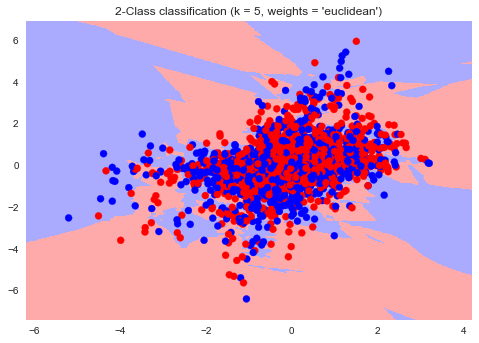

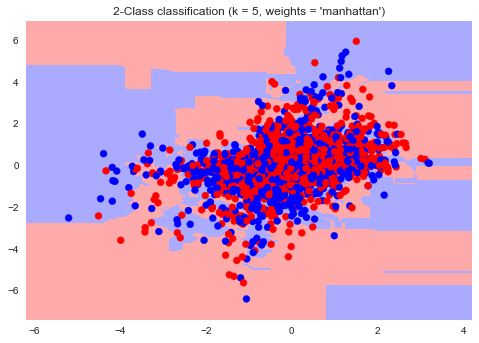

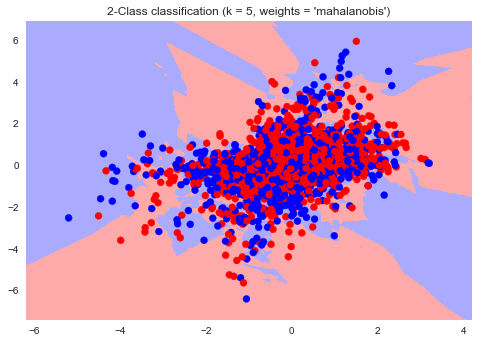

In [70]:
from matplotlib.colors import ListedColormap

metrics = ['euclidean', 'manhattan', 'mahalanobis']
features = train_X_scaled[:, [12, 14]]
labels = train_y

k = 5 # to make our results comparable, I select the same number of neighbours in all cases

for metric_ in metrics:
    if (metric_ == 'mahalanobis'):
        model = KNeighborsClassifier(n_neighbors = 5, metric = metric_, 
                                     algorithm='brute', 
                                     metric_params={'V': np.cov(features)}) 
        model.fit(features, labels)                                         
        plot_decision_rule(model, features, labels, k)
        
    else:
        model = KNeighborsClassifier(n_neighbors = 5, metric = metric_)
        model.fit(features, labels)
        plot_decision_rule(model, features, labels, k)

**Conclusion to A.3:** <br>
it can be seen from the plots above that it is hard to classify the objects based on a lagged 1 day return and 5 day momentum features. Also, we see that the decision boundaries have different shapes. This is because of the metric. For example, we see that the KNN algoirthm based on Manhattan metric has a quite different shape (a sort of linear shapes) from others I fixed the hyperparameter equal to 5 (even though it is not optimal for the algorithm based on Mahalanobis metric) and varied the type of a metric.<br>
This experiment is a good confirmation that we need to think carefully about what kind of data we have. After that it will be easier to figure out based on which metric we need to build our algorithm.

**What is ‘lazy’ about classification with KNN?**<br>
Lazy learning is the type of learning where the function is only approximated locally and all computation is deferred until function evaluation. So, the algorithm does not perform generalization until a quiry is made (as we have seen with logistic estimator). While computing, I have noticed that the algorithm is also quite memory and computationally intensive. 
___

<br>

### B. Prediction Quality and Bias (each chosen classifier)

### Task B.1

#### Logistic Classifier

We select logistic classifier with l1 regularization for this subsection.

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]} # regularization parameters
cv = 3 # number of folds for k-fold in grid search
penalty = 'l1' # regularization type

#### Logistic Classifier: Learning

In [72]:
estimator_logistic = LogisticRegression(penalty, solver='liblinear', max_iter = 1000) # create esimator
optimizer_logistic = GridSearchCV(estimator_logistic, param_grid, scoring = 'accuracy', cv = cv) # perform grid search
optimizer_logistic.fit(train_X_scaled,  train_y)
logistic_l1_prediction = optimizer_logistic.predict(test_X_scaled)

#### Logistic Classifier: Confusion matrix

In [73]:
from sklearn.metrics import classification_report 
print('Confusion Matrix. Logistic classfier, regularization: l2.')
print()
print(classification_report(test_y, logistic_l1_prediction))

Confusion Matrix. Logistic classfier, regularization: l2.

              precision    recall  f1-score   support

        -1.0       0.50      0.77      0.61       549
         1.0       0.51      0.24      0.32       551

    accuracy                           0.50      1100
   macro avg       0.51      0.51      0.47      1100
weighted avg       0.51      0.50      0.47      1100



#### Logistic Classifier: Area under ROC curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.515


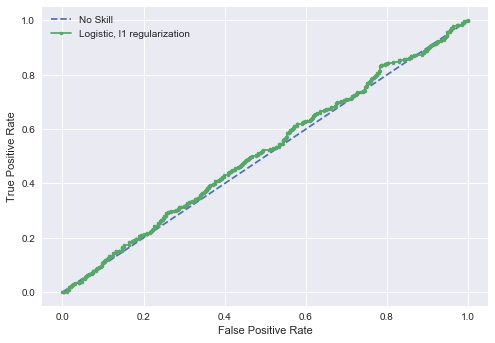

In [74]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(test_y))]
# predict probabilities
lr_probs = optimizer_logistic.predict_proba(test_X_scaled)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
lr_auc = roc_auc_score(test_y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic, l1 regularization')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Intemediate conclusion on the logistic classifier**:<br>
Our algoirthm does not demonstrate good performance in terms of ROC_AUC curve. Actually, it shows as good performance as if we would toss a fair coin.

##### Support Vector Machines

##### Support Vector Machines: Learning

In [75]:
soft_margin = 10
SVM_2D_soft= SVC(C=soft_margin, probability=True)
SVM_2D_soft = SVM_2D_soft.fit(train_X_scaled, train_y)
SVM_2D_soft_prediction = SVM_2D_soft.predict(test_X_scaled)

##### Support Vector: Confusion matrix

In [76]:
print('Confusion Matrix. Support Vector Machine, C: 1000.')
print()
print(classification_report(test_y, SVM_2D_soft_prediction))

Confusion Matrix. Support Vector Machine, C: 1000.

              precision    recall  f1-score   support

        -1.0       0.51      0.48      0.50       549
         1.0       0.51      0.54      0.53       551

    accuracy                           0.51      1100
   macro avg       0.51      0.51      0.51      1100
weighted avg       0.51      0.51      0.51      1100



##### Support Vector Machines: Area under ROC curve

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.502


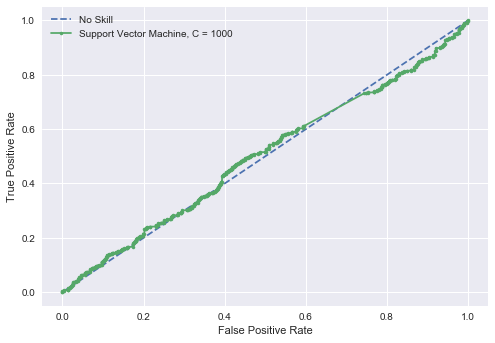

In [77]:
ns_probs = [0 for _ in range(len(test_y))]
# predict probabilities
lr_probs = SVM_2D_soft.predict_proba(test_X_scaled)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
lr_auc = roc_auc_score(test_y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Support Vector Machine, C = 1000')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

##### K-Nearest Neighbours (KNN)

##### KNN: Lazy learning

In [78]:
k = 5
KNN = KNeighborsClassifier(n_neighbors = 5, metric = metric_, algorithm='brute', 
                           metric_params={'V': np.cov(features)}) 
KNN_fit = KNN.fit(train_X_scaled, train_y)
KNN_prediction = KNN_fit.predict(test_X_scaled)

###### KNN: Сonfusion matrix

In [79]:
print('Confusion Matrix. KNN, K: 5.')
print()
print(classification_report(test_y, KNN_prediction))

Confusion Matrix. KNN, K: 5.

              precision    recall  f1-score   support

        -1.0       0.51      0.46      0.48       549
         1.0       0.51      0.55      0.53       551

    accuracy                           0.51      1100
   macro avg       0.51      0.51      0.51      1100
weighted avg       0.51      0.51      0.51      1100



No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.503


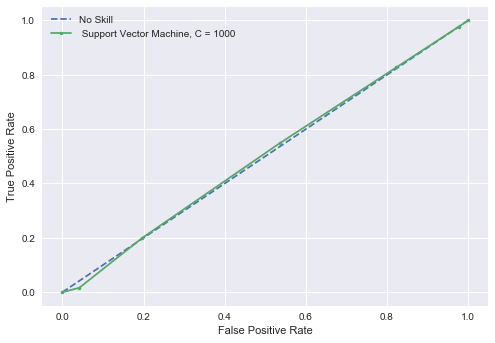

In [80]:
ns_probs = [0 for _ in range(len(test_y))]
# predict probabilities
lr_probs = KNN_fit.predict_proba(test_X_scaled)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_y, ns_probs)
lr_auc = roc_auc_score(test_y, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label=' Support Vector Machine, C = 1000')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Conclusion on B.1:**<br>
In this section we considered several candidates from the point of ROC AUC curve and confusion matrix. The results are not promising though. The precicison is almost on the same level for all models, however, what I noticed that for logistic classifier recall for negative returns is much higher than for other models.

___

#### Task B.2 

Let us consider a feature selection for two classifiers Logistic and SVM. We select only these two classifier, because it is possible explicitly show a feature selection process.
In logistic regression, regularization (l1) effectively plays a role of a feature selection mechanism.
In other cases, we need to come up with feature selection methods. First of all, let us demonstrate again how regularization works in terms of a feature selecion. From A.1, we demonstrate the ouput (retrieve from A.1) as

In [81]:
print('Training set coefficients: ')
print(logistic_l1_coef)
print()
print('The best parameter:')
print(optimizer_logistic_l1.best_params_)
print()
print('The best achieved score:')
print(optimizer_logistic_l1.best_score_)

Training set coefficients: 
[ 0.          0.         -0.0991541   0.          0.         -0.0225411
  0.          0.04852767  0.         -0.03839275  0.          0.
 -0.05162265  0.         -0.02210439  0.          0.          0.
 -0.01046163  0.0043314   0.00124791]

The best parameter:
{'C': 0.1}

The best achieved score:
0.5162995594713656


In [82]:
X.columns

Index(['Adj Close', 'Open', 'Close', 'High', 'Low', 'Volume', 'ret_1', 'ret_2',
       'ret_3', 'ret_4', 'ret_5', 'ret_over_5d', 'ret_over_21d', 'MOM_1d',
       'MOM_5d', 'MA_5d', 'EMA_7d', 'std_21d', 'ret_6', 'ret_7', 'ret_8'],
      dtype='object')

**Logistic Classifier**

In [83]:
from sklearn.feature_selection import RFE
model = LogisticRegression('l1', solver='liblinear')
rfe = RFE(model, 6)
fit = rfe.fit(train_X_scaled, train_y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 6
Selected Features: [False False  True False False  True False  True False  True False False
  True False  True False False False False False False]
Feature Ranking: [16 15  1 14 13  1  6  1 12  1  4  9  1  7  1 11 10  8  2  3  5]


In [84]:
features_ranks = fit.ranking_.tolist()
best_features = [i for i, e in enumerate(features_ranks) if e == 1]

In [85]:
X.columns[best_features]

Index(['Close', 'Volume', 'ret_2', 'ret_4', 'ret_over_21d', 'MOM_5d'], dtype='object')

In [86]:
new_logit = LogisticRegression('l1', solver='liblinear')
new_logit_fit = new_logit.fit(train_X_scaled[:,fit.ranking_[best_features]], train_y)
new_logit_predictions = new_logit_fit.predict(test_X_scaled[:,fit.ranking_[best_features]])

In [87]:
new_logit_auc = roc_auc_score(test_y, new_logit_predictions)
print('Logit_model_with_selected_features_L1_spec_auc:')
print(new_logit_auc)

Logit_model_with_selected_features_L1_spec_auc:
0.5144562461363509


Here we restricted the set of features up to 5. We notice that the roc_auc measure improved. It seems that feature selection positive affects the model's performance.

**SVM (linear specification)**

Let us try to find optimal features just by using univariate feature selection with F-test for feature scoring and plot the result.

In [88]:
# Univariate feature selection with F-test for feature scoring
# We use the default selection function to select the four
# most significant features
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif

X_indices = np.arange(X.shape[-1])
selector = SelectKBest(f_classif, k=5)
selector.fit(train_X_scaled, train_y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

Text(0.5, 0, 'Univariate Score')

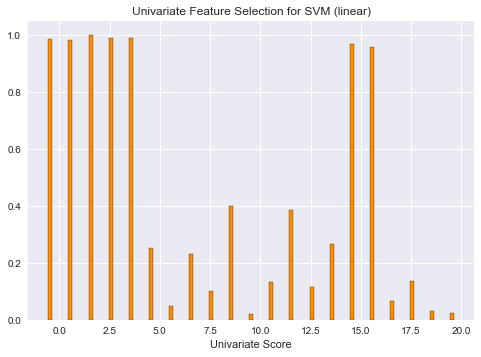

In [89]:
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
plt.title('Univariate Feature Selection for SVM (linear)')
plt.xlabel('Feature Number')
plt.xlabel('Univariate Score')

It is a bit strange that the algorithm selected all prices.

Let us demonstrate how feature selection works for SVM (linear). Actually, with a linear type of model, we do not have that big room to play with the value of hyperparameter since the data is not really linearly separable.

Classification accuracy without selecting features: 0.490


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Weight')

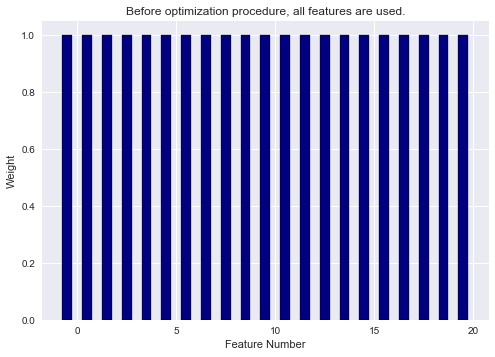

In [90]:
clf = LinearSVC(C=10, max_iter=10000)
clf.fit(train_X_scaled, train_y)
print('Classification accuracy without selecting features: {:.3f}'
      .format(clf.score(test_X_scaled, test_y)))

svm_weights = np.abs(clf.coef_[-1]).sum(axis=0)
svm_weights /= svm_weights.sum()

plt.bar(X_indices - .5, svm_weights, width=.5, label='SVM weight',
        color='navy', edgecolor='black')

plt.title('Before optimization procedure, all features are used.')
plt.xlabel('Feature Number')
plt.ylabel('Weight')

Classification accuracy after univariate feature selection: 0.547


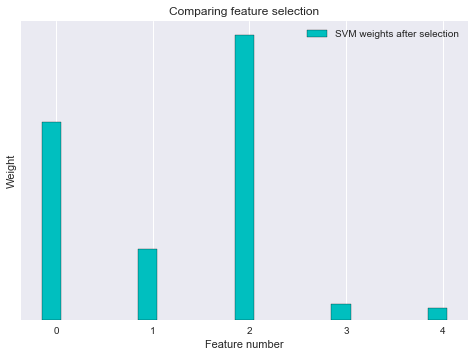

In [198]:
from sklearn.pipeline import make_pipeline

clf_selected = make_pipeline(SelectKBest(f_classif, k=5), LinearSVC(C=1, max_iter= 10000))
clf_selected.fit(train_X_scaled, train_y)
print('Classification accuracy after univariate feature selection: {:.3f}'
      .format(clf_selected.score(test_X_scaled, test_y)))

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

plt.bar(X_indices[selector.get_support()] - .05, svm_weights_selected,
        width=.2, label='SVM weights after selection', color='c',
        edgecolor='black')

plt.title("Comparing feature selection")
plt.xlabel('Feature number')
plt.ylabel('Weight')
plt.yticks(())
plt.axis('tight')
plt.legend(loc='upper right')
plt.show()


idx_selected_features = X_indices[selector.get_support()].tolist()
svl_linear_best = clf_selected

The accuracy of SVM model actually increased from 0.508 to 0.547 percent.

**Bagging: Logistic**

In [95]:
from sklearn.ensemble import BaggingRegressor 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import r2_score

logit_estimator_l1 = LogisticRegression(penalty = 'l1', C=1, solver='liblinear')
bagging_logit = BaggingRegressor(logit_estimator_l1, n_estimators=100,random_state = 1, n_jobs=-1)
bagging_logit.fit(train_X_scaled, train_y)
bagging_logit_predictions = bagging_logit.predict(test_X_scaled)
print(roc_auc_score(test_y,bagging_logit_predictions))

0.5093504441336996


**Bagging: KNN**

In [96]:
bagging_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), max_samples=0.5, 
                                max_features=0.5, n_estimators=100, random_state = 1)

bagging_KNN.fit(train_X_scaled, train_y)
bagging_KNN_predictions = bagging_KNN.predict(test_X_scaled)
print(roc_auc_score(test_y,bagging_KNN_predictions))
print(classification_report(test_y, bagging_KNN_predictions))

0.5162132767381049
              precision    recall  f1-score   support

        -1.0       0.52      0.43      0.47       549
         1.0       0.51      0.60      0.55       551

    accuracy                           0.52      1100
   macro avg       0.52      0.52      0.51      1100
weighted avg       0.52      0.52      0.51      1100



**Bagging: SVM**

In [101]:
bagging_SVM = BaggingClassifier(SVC(C=100, probability=True), max_samples=0.5, 
                                max_features=0.5, n_estimators=100, random_state = 1)
bagging_SVM.fit(train_X_scaled, train_y)
bagging_SVM_predictions = bagging_SVM.predict(test_X_scaled)
print(roc_auc_score(test_y,bagging_SVM_predictions))

0.5


**Bagging**

In [102]:
bagging_reg = BaggingRegressor(random_state = 1) 
bagging_reg.fit(train_X_scaled, train_y) 
bagging_pred = bagging_reg.predict(test_X_scaled)
print(roc_auc_score(test_y,bagging_pred))

0.5132215313108472


In [103]:
from matplotlib.colors import ListedColormap
from sklearn import tree, ensemble
from sklearn.model_selection import cross_validate


**Bagging using  ensemble and decision trees**

In [104]:
dtree = tree.DecisionTreeClassifier()
bagging = ensemble.BaggingClassifier(dtree, n_estimators=1000)
bagging.fit(train_X_scaled, train_y) 
bagging_pred = bagging.predict(test_X_scaled)
print(roc_auc_score(test_y,bagging_pred))
# bag_scores = cross_validate(bagging, train_X_scaled, train_y, cv=cv)

0.50099835040777


**Make recommendation on how to reduce misclassified negative returns.**<br>

* We can tune our algorithm in such a way to reduce the number of false negative predictions. First of all, we can add in our loss function a penalty for wrongly predicted negative returns (it is not difficult to this at least with logistic classifier).<br>
* We can vary a threshold above which we assign to a class.
* In addition, we can consider balancing our samples.


___

### Task B.3

From the analysis above, I suggest to use KNN (Bagging version) and SVM (linear with determined set of features).

Text(0.5, 1.0, 'Transition Probabilities for KNN (Bagging) classifier. Correct predicted negative returns - yellow')

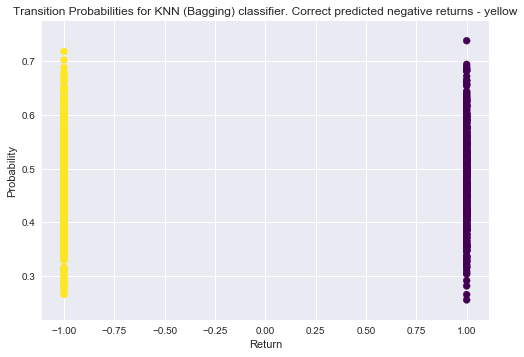

In [504]:
bagging_KNN_tr_probs = bagging_KNN.predict_proba(test_X_scaled) # predictions from previous classifier
svm_linear_tr_probs = SVM_lin_new._predict_proba_lr(test_X_scaled[:,idx_selected_features]) # predictions from previous classifier
marker_negative = test_y==-1
marker_postive = test_y==1
plt.scatter(test_y, bagging_KNN_tr_probs[:,0], c = marker_negative, zorder=29, cmap='viridis')
plt.xlabel('Return')
plt.ylabel('Probability')
plt.title('Transition Probabilities for KNN (Bagging) classifier. Correct predicted negative returns - yellow')

Text(0.5, 1.0, 'Transition Probabilities for KNN (Bagging) classifier. Correct predicted positive returns- yellow')

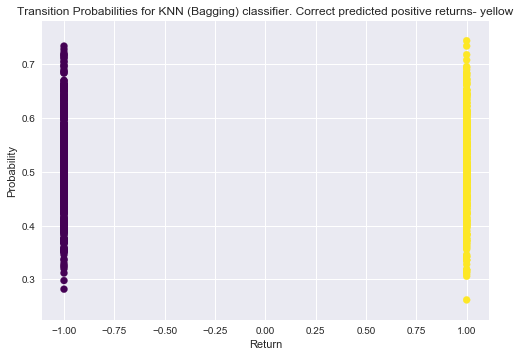

In [505]:
plt.scatter(test_y, bagging_KNN_tr_probs[:,1], c = marker_postive, zorder=29, cmap='viridis')
plt.xlabel('Return')
plt.ylabel('Probability')
plt.title('Transition Probabilities for KNN (Bagging) classifier. Correct predicted positive returns- yellow')

Text(0.5, 1.0, 'Transition Probabilities for SVM classifier. Correct predicted negative probs - yellow')

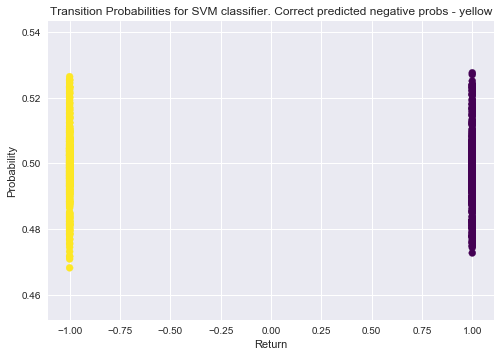

In [506]:
marker_negative = test_y==-1
marker_postive = test_y==1
plt.scatter(test_y, svm_linear_tr_probs[:,0], c = marker_negative, zorder=29, cmap='viridis')
plt.xlabel('Return')
plt.ylabel('Probability')
plt.title('Transition Probabilities for SVM classifier. Correct predicted negative probs - yellow')

Text(0.5, 1.0, 'Transition Probabilities for SVM classifier. Correct predicted positive probs - yellow')

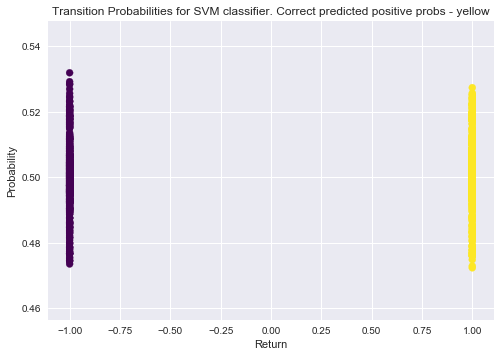

In [163]:
marker_negative = test_y==-1
marker_postive = test_y==1
plt.scatter(test_y, svm_linear_tr_probs[:,1], c = marker_postive, zorder=29, cmap='viridis')
plt.xlabel('Return')
plt.ylabel('Probability')
plt.title('Transition Probabilities for SVM classifier. Correct predicted positive probs - yellow')

In [507]:
knn_bagging_pred_ret = bagging_KNN.predict_proba(X_scaled)
svm_pred_ret = SVM_lin_new._predict_proba_lr(X_scaled[:,idx_selected_features])

In [508]:
df['KNN_predicted_return'] = df['return'] * knn_bagging_pred_ret[:,1]
df['SVM_predicted_return'] = df['return'] * svm_pred_ret[:,1]

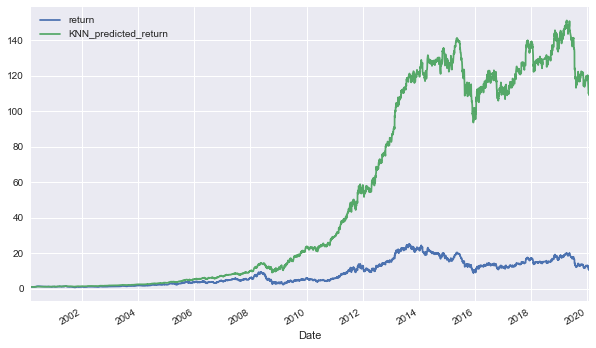

In [509]:
df[['return', 'KNN_predicted_return']].cumsum().apply(np.exp).plot(figsize=(10, 6));

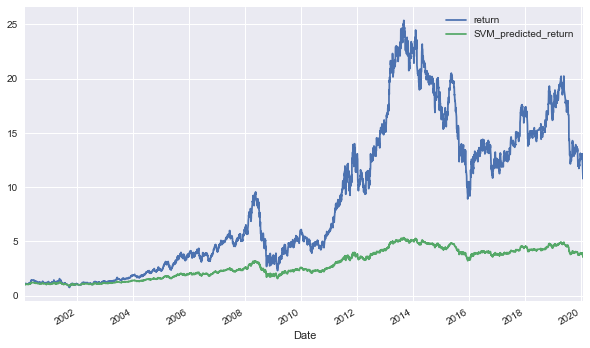

In [442]:
df[['return', 'SVM_predicted_return']].cumsum().apply(np.exp).plot(figsize=(10, 6));

**Kelly Optimal Allocation**

In [522]:
thresh_knn = 0.632
kelly_returns_KNN = []
for i in range(len(knn_bagging_pred_ret[:,1])):
    if (knn_bagging_pred_ret[i,1] > thresh_knn):
        kelly_returns_KNN.append(knn_bagging_pred_ret[i,1]*df['return'][i])
    else:
        kelly_returns_KNN.append(0)
df['KNN_kelly_predicted_return'] = kelly_returns_KNN

In [523]:
thresh_svm = 0.50
kelly_returns_SVM = []
for i in range(len(swm_pred_ret[:,1])):
    if (swm_pred_ret[i,1] > thresh_svm):
        kelly_returns_SVM.append(swm_pred_ret[i,1]*df['return'][i])
    else:
        kelly_returns_SVM.append(0)
df['SVM_kelly_predicted_return'] = kelly_returns_SVM

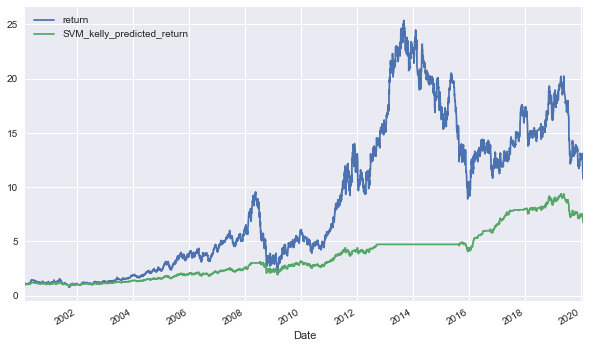

In [524]:
df[['return', 'SVM_kelly_predicted_return']].cumsum().apply(np.exp).plot(figsize=(10, 6));

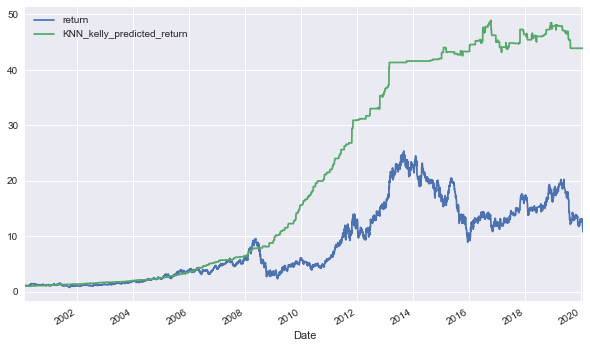

In [525]:
df[['return', 'KNN_kelly_predicted_return']].cumsum().apply(np.exp).plot(figsize=(10, 6));

#### Task B.4

Probability density function of Normal distribution can be denoted as

$${\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}} \quad(1)$$<br>

Also, we know that given a measure $\theta$, we define an exponential family of probability distributions as those distributions whose density (relative to $\theta$) have the following general form:
<br>
$${\displaystyle f(x;\mu)=\exp \left[a(x)\cdot b(\mu ) + c(\mu ) + d(x)\right]} \quad(2)$$ <br>

In case of Normal distribution $\theta = \mu$.<br><br>
We can open parthesis in 1 as follows
$${\displaystyle f(x)=\frac {1}{\sqrt {2\pi}}e^{\left({{\frac {\mu}{\sigma^{2}}x-\frac {\mu}{2\sigma^{2}}x^{2}-{\frac {1}{2\sigma^{2}}\mu^{2}-\log{\sigma}}}}\right)}} \quad(3)$$<br>

As I understand, in the assignment, it is assumed that $\mu$ is not known and variance $\sigma^{2}$ is known $\sigma^{2}_0$.

$${\displaystyle f(x)=\frac {1}{\sigma {\sqrt {2\pi}}}e^{\left({-\frac {1}{2\sigma^{2}}x^{2} + {\frac {\mu}{\sigma^{2}}x-{\frac {1}{2\sigma^{2}}\mu^{2}}}}\right)}=e^{\left({{\frac {\mu}{\sigma^{2}}x-{\frac {\mu^{2}}{2\sigma^{2}}-\frac {x^{2}}{2\sigma^{2}}-\log{\sigma {\sqrt {2\pi}}}}}}\right)}} $$<br>

Thus, we can define functions $a(x), b(\mu), c(\mu), d(x)$ as follows
$$a(x)=x$$<br>
$$b(\mu)= \frac {\mu}{\sigma^{2}}$$
$$c(\mu)=-\frac {\mu^{2}}{2\sigma^{2}}$$
$$d(x)=log\Bigg({\frac{1}{\sigma {\sqrt {2\pi }}}\cdot\exp \left[\frac {-x^{2}}{2\sigma^{2}}\right]}\Bigg)$$<br>

#### Test on another company within the industry (XOM)

Let us perform a validation of our model using the data from another company within the oil industry.<br>
Below, we perform the same steps that we did above, but we test only for a KNN model to keep it short.
Generally, we find the same performance, slightly lower recall and a similar graph for cumulative returns.

In [596]:
XOM_data = yf.download("XOM", start="2000-01-01", end="2020-01-31", period = '1d')
XOM_adj_close = XOM_data['Adj Close']

df = pd.DataFrame() # create empty pandas dataframe
df['return'] = np.log(XOM_adj_close / XOM_adj_close.shift(1)) # create logarithmic returns
df['return_sign'] = np.sign(df['return']) # create a categorical variable with two classes: 1 for a positive return and -1 for a negative return

df['Adj Close'] = COG_data['Adj Close'].shift(1) # lagged adjusted close price
df['Open'] = COG_data.Open.shift(1) # lagged open price
df['Close'] = COG_data.Close.shift(1) # lagged close price
df['High'] = COG_data.High.shift(1) # lagged high price
df['Low'] = COG_data.Low.shift(1) # lagged low price
df['Volume'] = COG_data.Volume.shift(1) # lagged Volume

lags = 8
cols = []
for lag in range(1, lags+1):
    col_ret = 'ret_%d' % lag
    df[col_ret] = df['return'].shift(lag)
    cols.append(col_ret)

df['ret_over_5d'] = np.log(df['Adj Close'] / df['Adj Close'].shift(5)) # lagged 5-day return
df['ret_over_21d'] = np.log(df['Adj Close'] / df['Adj Close'].shift(21)) # lagged 21-day return
df['MOM_1d'] = df['Adj Close'].diff(1) # lagged 1-day adjusted close price difference
df['MOM_5d'] = df['Adj Close'].diff(5) # lagged 5-day adjusted close price difference
df['MA_5d'] = df['Adj Close'].rolling(5).mean() # lagged 5-day adjusted close price moving average 
df['EMA_7d'] = EMAcreate(df['Adj Close'], 7) # lagged 7-day adjusted close price exponential moving average 
df['std_21d'] = df['ret_1'].rolling(21).std() # based on 1-day log return, 21-day return standart deviation
df.dropna(inplace = True)

df = df.loc[~(df==0.0).all(axis=1)]
df = df[df!=0].dropna()
np.unique(np.array(df['return_sign']))

features_names = ['Adj Close', 'Open', 'Close', 'High', 'Low',
                  'Volume', 'ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5', 'ret_over_5d',
                  'ret_over_21d', 'MOM_1d', 'MOM_5d', 'MA_5d', 'EMA_7d', 'std_21d',
                  'ret_6', 'ret_7', 'ret_8']

X = df[features_names] # features data set
y = df['return_sign'] # object to predict

size = 1100
train_y = y[:-size]
test_y = y[-size:]
train_X = X.iloc[:-size,:]
test_X = X.iloc[-size:,:]
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)
X_scaled = np.concatenate((train_X_scaled, test_X_scaled), axis=0)


[*********************100%***********************]  1 of 1 completed


In [597]:
estimator_euclidean = KNeighborsClassifier(metric = 'euclidean') # set up KNN estimator
param_grid = {'n_neighbors': np.arange(1,100, 1).tolist()} # set up the number of neighbours
cv = 3
optimizer = GridSearchCV(estimator_euclidean, param_grid, scoring = 'accuracy', cv = cv) 
optimizer.fit(train_X_scaled, train_y)
estimator_euclidean.get_params

<bound method BaseEstimator.get_params of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')>

In [598]:
print('The accuracy of the optimized KNN algorithm based on Euclidean metric:')
KNeighborsClassifier.score(optimizer, test_X_scaled, test_y)

The accuracy of the optimized KNN algorithm based on Euclidean metric:


0.5063636363636363

In [599]:
bagging_KNN = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), max_samples=0.5, 
                                max_features=0.5, n_estimators=100, random_state = 1)
bagging_KNN.fit(train_X_scaled, train_y)
bagging_KNN_predictions = bagging_KNN.predict(test_X_scaled)
print(roc_auc_score(test_y,bagging_KNN_predictions))
print(classification_report(test_y, bagging_KNN_predictions))

0.5167286552607653
              precision    recall  f1-score   support

        -1.0       0.51      0.46      0.48       545
         1.0       0.52      0.58      0.55       555

    accuracy                           0.52      1100
   macro avg       0.52      0.52      0.52      1100
weighted avg       0.52      0.52      0.52      1100



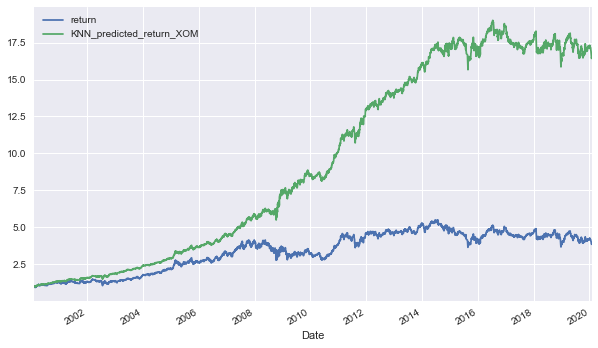

In [600]:
bagging_KNN_tr_probs = bagging_KNN.predict_proba(X_scaled)
df['KNN_predicted_return_XOM'] = df['return'] * bagging_KNN_tr_probs[:,1]
df[['return', 'KNN_predicted_return_XOM']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [601]:
thresh_knn = 0.64
kelly_returns_KNN_XOM = []
for i in range(len(bagging_KNN_tr_probs[:,1])):
    if (bagging_KNN_tr_probs[i,1] > thresh_knn):
        kelly_returns_KNN_XOM.append(bagging_KNN_tr_probs[i,1]*df['return'][i])
    else:
        kelly_returns_KNN_XOM.append(0)
df['KNN_kelly_predicted_return_XOM'] = kelly_returns_KNN_XOM

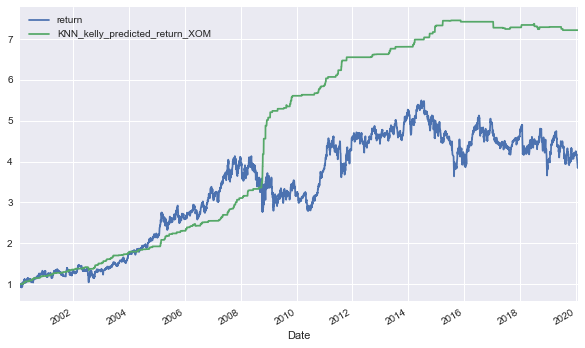

In [602]:
df[['return', 'KNN_kelly_predicted_return_XOM']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Conclusion

In this assignment we tested a variety of algorithms. We started from a logistic regression and moved toward such algorithms as KNN and SVM. Despite our effort to increase the performance of all models by trying to normilize (scale) and balance a feature space, select features, we have not achieved impressive performance. This exercise demonstrates that daily returns is quite hard to predict. However, we could consider some procedures for feature selection like PCA, but due to the shortage of time, we did not do this (potential area to test). However, I do not lose hope that by considering more complex features and models, we can achieve some promising results (at least on different time horizons).